In [1]:
from source import *
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import trange
from IPython.display import clear_output
import copy

### Make an environment ("CartPole-v1")

In [2]:
env_name = "CartPole-v1"
env = make_env(env_name)

state_shape = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

### Build agent network and target network

In [3]:
network = tf.keras.models.Sequential()
network.add(tf.keras.layers.Input(shape=(state_shape[0],)))
network.add(tf.keras.layers.Dense(192, activation="relu"))
network.add(tf.keras.layers.Dense(256, activation="relu"))
network.add(tf.keras.layers.Dense(64,  activation="relu"))
network.add(tf.keras.layers.Dense(n_actions))

target = copy.deepcopy(network)

network.summary()

2022-07-11 10:43:27.014264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram://45e22cfe-f48b-4e30-bb52-6f2619e015e7/assets
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               960       
                                                                 
 dense_1 (Dense)             (None, 256)               49408     
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 66,946
Trainable params: 66,946
Non-trainable params: 0
_________________________________________________________________


### Define a DQNAgent

In [4]:
agent = DQNAgent(state_shape, n_actions, network, epsilon=0.5)

#### Evaluate the agent before training

In [5]:
evaluate(env, agent, n_games=1)

46.0

### Define Target Network

In [6]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, target, epsilon=0.5)
target_network.model.set_weights(agent.model.get_weights())

#### Fill experience replay with some samples using full random policy

In [7]:
exp_replay = ReplayBuffer(10_000)
for i in range(100):
    play_and_record(state, agent, env, exp_replay, n_steps=100)
    if len(exp_replay) == 10_000:
        break
print(len(exp_replay))

/home/ubuntu/venv/deep_rl/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


10000


In [8]:


#setup some parameters for training
timesteps_per_epoch = 1
batch_size = 32
total_steps = 50_000

#init Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
# set exploration epsilon 
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = 2 * 10_000

# setup spme frequency for loggind and updating target network
loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

# to clip the gradients
max_grad_norm = 5000

In [9]:
mean_rw_history = []
td_loss_history = []

buffer size = 10000, epsilon = 0.05000


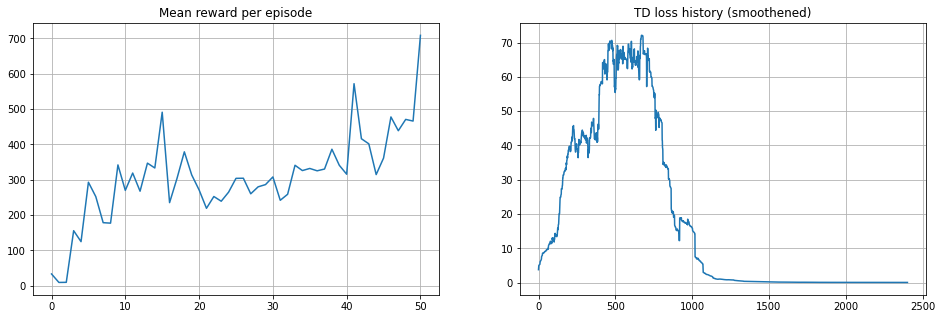

100%|█████████████████████████████████████| 50001/50001 [35:27<00:00, 23.50it/s]


In [10]:
state = env.reset()
for step in trange(total_steps + 1):
    # reduce exploration as we progress
    agent.epsilon = epsilon_schedule(start_epsilon, end_epsilon, step, eps_decay_final_step)
    # take timesteps_per_epoch and update experience replay buffer
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)
    # train by sampling batch_size of data from experience replay
    states, actions, rewards, next_states, done_flags = exp_replay.sample(batch_size)
    with tf.GradientTape() as tape:
        # loss = <compute TD loss>
        loss = compute_td_loss(agent, target_network, 
                               states, actions, rewards, next_states, done_flags,                  
                               gamma=0.99)
    gradients = tape.gradient(loss, agent.model.trainable_variables)
    clipped_grads = [tf.clip_by_norm(g, max_grad_norm) for g in gradients]
    optimizer.apply_gradients(zip(clipped_grads, agent.model.trainable_variables))
    if step % loss_freq == 0:
        td_loss_history.append(loss.numpy())
    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.model.set_weights(agent.model.get_weights())
    if step % eval_freq == 0:
        # eval the agent
        mean_rw_history.append(evaluate(
            make_env(env_name, seed=step), agent, n_games=3, greedy=True, t_max=1000)
        )
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))
        plt.figure(figsize=[16, 5])
        plt.subplot(1, 2, 1)
        plt.title("Mean reward per episode")
        plt.plot(mean_rw_history)
        plt.grid()
        assert not np.isnan(td_loss_history[-1])
        plt.subplot(1, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(smoothen(td_loss_history))
        plt.grid()
        plt.show()

In [11]:
final_score = evaluate(
  make_env(env_name),
  agent, n_games=30, greedy=True, t_max=1000
)
print('final score:', final_score)

final score: 565.6333333333333


In [12]:
# Animate learned policy
save_dir='./videos/dqn/'
env = make_env(env_name)
generate_animation(env, agent, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)

Got reward: 662.0


# Assignment #1

In [ ]:
# try to run this for another environment of your choice from OpenAI Gym
# try to enhance the network using various variants